## Detecting Recycleable Trash using Custom Object Detection

In this notebook, we work with an image dataset of 4 different waste categories: glass, paper, plastic, and metal. Our goal is to create an object detection model that will both locate and classify recycleable trash from an image. To do so, we use Facebook's detectron2 API to create our custom object detection model using transfer learning from detectron2's model zoo. Our study includes testing with two different base models that are implementing different approaches for object detection as well as analyzing the effect of different kinds of perturbations inserted in our training data on the performance of our models.

### Imports

In [1]:
import os
import cv2
import json
import glob
import random
import detectron2
import numpy as np
import pandas as pd

In [2]:
%%capture

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from IPython.display import display, Image
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader

from IPython.display import HTML
from matplotlib import pyplot as plt

%matplotlib inline
setup_logger()

In [3]:
%%capture
from to_import import *

### The Dataset

We found the dataset, TrashNet, online, which was created by two students at Stanford University for an image classification model ([Github link](https://github.com/garythung/trashnet)). Here are some example images from the dataset.

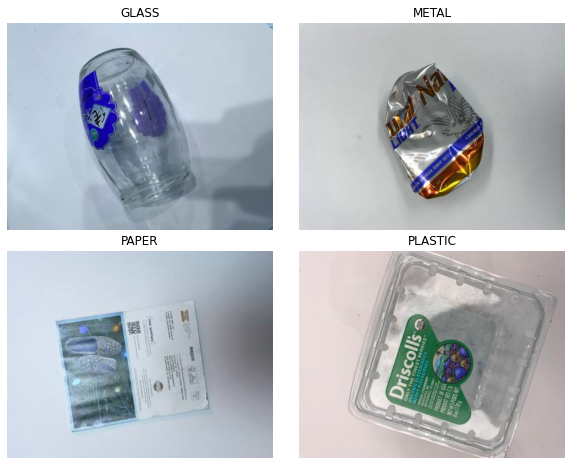

In [14]:
filenames = ["glass144.jpg", "metal102.jpg", "paper19.jpg", "plastic103.jpg"]
labels = ["GLASS", "METAL", "PAPER", "PLASTIC"]

i = 0
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
for file in filenames:
    image = cv2.imread("examples/" + file)
    row = i // 2
    col = i % 2
    axes[row, col].axis("off")
    axes[row, col].imshow(image, aspect="auto")
    axes[row, col].set_title(labels[i])
    i += 1
    
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

Because we are interested in building an object detection model instead of just an image classification model, our dataset has to have bounding boxes with respective labels (i.e. annotations) around the objects in the images. We could not find a pre-made dataset that has these annotations for recycleable trash; therefore, we used labelImg software to draw the bounding boxes manually for all 1969 images we used at the end. An example of how labelImg was used to create these bounding boxes can be seen in the screen shot below.

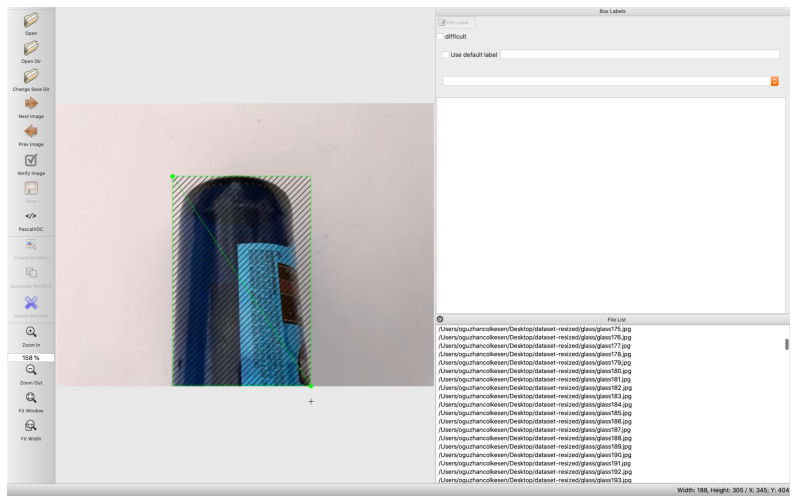

In [35]:
# For some reason, the markdown image does not show up on GitHub
# so we use matplotlib to print the figure

image = cv2.imread("labelImg_ss.png")
plt.rcParams['figure.figsize'] = [18, 9]
plt.imshow(image)
plt.axis("off")
plt.show()

At the end of this step, we have created 1971 annotations for 1969 images, which are distributed across our four labels as follows.

||Glass|Metal|Paper|Plastic|
|:--------------:|:-------:|:-------:|:-------:|:-------:|
|Number of Images|586|497|477|411|

Therefore, we conclude our dataset is relatively balanced for the four classes we have.

### Data Pre-Processing

After we annotate our data, we need to convert the dataset into a format that detectron2 could use, which is a .json file. The structure of this .json file is that each entry has fields "image_id", "file_name", "height", "width", and "annotations" that holds a list of bounding boxes in that image. To assist us with this conversion, we used an online tool called Roboflow, which in addition to creating the .json files also splits our dataset into train, test, and validation sets and adds perturbations to the training data. We use Roboflow to resize all of our images to 250x250 pixels for faster training and smaller memory usage to not run into any memory issues during training.

We experiment with three kinds of perturbations to evaluate their effect on the performance of our models. The first variation includes:

* Vertical flip
* Horizontal flip
* 90 degrees rotation
* Rotation (-45% - 45%)
* Crop (0% - 20%)
* Brightness (-35% - 35%)

In the second variation, we introduce a new set of perturbations:

* Vertical flip
* Horizontal flip
* 90 degrees rotation
* Brightness (-35% - 35%)
* Static noise (Up to 5% of pixels)

In the third variation, we keep all the perturbations from the second variation except for static noise. This allows us to isolate the effect of adding noise as a data augmentation method on the model's performance.

Roboflow generates 3 perturbated versions of each of our training images. After downloading the generated dataset with its .json file, we do some changes to its format and add it to detectron2's data catalog.

In [16]:
def get_board_dicts(imgdir):
    json_file = imgdir+"/_annotations.coco.json" #Fetch the json file
    new_dict = []
    with open(json_file) as f:
        dataset_dicts = json.load(f)
    for i in range(len(dataset_dicts["images"])):
        entry = {}
        entry["image_id"] = int(dataset_dicts["images"][i]["id"])
        entry["file_name"] = imgdir+"/"+dataset_dicts["images"][i]["file_name"]
        entry["height"] = dataset_dicts["images"][i]["height"]
        entry["width"] = dataset_dicts["images"][i]["width"]
        
        annots = []
        
        for j in range(len(dataset_dicts["annotations"])):
            annot = {}
            if (entry["image_id"] == int(dataset_dicts["annotations"][j]["image_id"])):
                annot["bbox"] = dataset_dicts["annotations"][j]["bbox"]
                annot["bbox_mode"] = BoxMode.XYWH_ABS
                annot["category_id"] = int(dataset_dicts["annotations"][j]["category_id"])
                annots.append(annot)
        
        entry["annotations"] = annots
        
        new_dict.append(entry)

    return new_dict

for d in ["test", "train", "valid"]:
    DatasetCatalog.register("trash_" + d, lambda d=d: get_board_dicts("DL_final/" + d))
    MetadataCatalog.get("trash_" + d).set(thing_classes=["garbage","glass","metal","paper","plastic"])
    
trash_metadata = MetadataCatalog.get("trash_train")
trash_test_metadata = MetadataCatalog.get("trash_test")

Below are the same example images from earlier with their bounding boxes visualized.

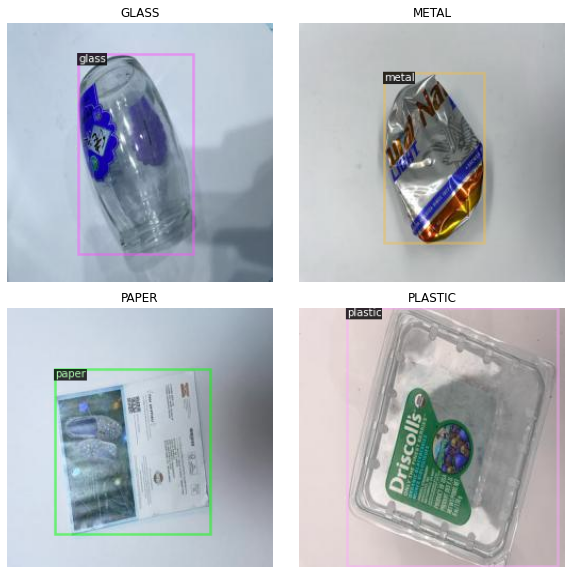

In [25]:
dataset_dicts = get_board_dicts("DL_final/test")

filenames = ["glass144", "metal102", "paper19", "plastic103"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
i = 0

for file in filenames:
    for d in dataset_dicts:
        if (file in d["file_name"] and "paper191" not in d["file_name"] and "paper197" not in d["file_name"]):
            img = cv2.imread(d["file_name"])
            visualizer = Visualizer(img[:, :, ::-1], metadata=trash_test_metadata)
            vis = visualizer.draw_dataset_dict(d)
            
            row = i // 2
            col = i %2
            axes[row, col].axis("off")
            axes[row, col].imshow(vis.get_image()[:, :, ::-1], aspect="auto")
            axes[row, col].set_title(labels[i])
            i += 1
            break
    
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

### Experiments

Before starting the development of any models, it is important to understand the nature of the task at hand and what measures we want to evaluate our models on. First, it is important to understand that we cannot use the same metrics as with classification models, because we want to evaluate our models on both detecting objects and classifying them correctly. Therefore, we have to disregard the effect of any true negatives where the model correctly predicted the absence of an object, because we could create infinitely many regions where there was no object and the model did not detect anything. This is the reason why we cannot comment on object detection models' accuracy metric. However, we can evaluate our models on precision and recall because they do not involve true negatives in their formulas.

* Recall: How many objects that belong to a class have been correctly detected and labeled by the model.
* Precision: Of the questions the objects that have been detected and classified, how many of them actually correspond to an object, which belongs to that class.

Of the two metrics reported above, we are more interested in precision over recall given the context of identifying recycleable trash. In this context, it is less harmful to have a false negative than a false positive. Saying an object is plastic when that object is glass might result in reducing the efficiency of recycling process because there would be an additional need to filter the recycled items, driving the cost of recycling up. On the other hand, if a metal goes into a landfill, we certainly are not recycling up to our full potential, but it is more favorable to keep the recycling costs down to incentivize recycling in the long run.

Furthermore, there is an additional metric to consider in object detection models, which is related to how well the model draws the bounding boxes. This metric is called IoU (Intersection-over-Union), which is calculated by dividing the intersection of the actual and predicted bounding boxes by their union. This concept is illustrated by the figure below where the blue box represents the actual bounding box and the green box is the model's prediction of it. Note that an IoU value of 1 would correspond to a perfect overlap of the two boxes.

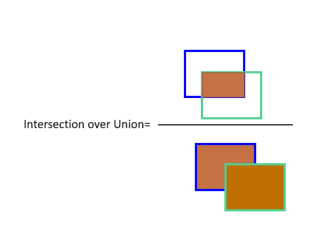

In [36]:
image = cv2.imread("iou.png")
plt.rcParams['figure.figsize'] = [8, 4]
plt.imshow(image)
plt.axis("off")
plt.show()

We can select different IoU thresholds to specify when our model correctly detects an object. For example, if the IoU for our model's prediction on an image is 0.6 and we pick 0.5 as the threshold, we would say that the model correctly detected the object. However, if the threshold was 0.8, the model would not have detected the object.  Because different thresholds have direct impact on precision and recall, we will evaluate how the performance of our models using precision and recall at different thresholds for IoU. To introduce new notation, AP50 would refer to the average precision metric over all classes when the IoU threshold is at 0.5 or 50%.

In the rest of this section, we will first talk about our experimentation with different types of data augmentation on the R101-FPN base model. Then, we will introduce another transfer learning model that had better performance in its original dataset and carry out the same kind of experimentation. After comparing the results of these two models and the models themselves, we will discuss the precision of our models for each label specifically. At last, we take the best-performing model and data augmentation method to generate some sample inferences on the test dataset images.

#### 1. Model 1 (R101-FPN)

The first model we picked from detectron2's model zoo is the model that had second best bounding box AP over all COCO Object Detection models, R101-FPN. COCO (Common Objects in Context) is a large-scale object detection dataset with 330,000 images with a total 171 classification categories. We expect a model that performs well for COCO to transfer that knowledge for detecting objects and classification to our TrashNet dataset as well. Obviously, our dataset is small and object detection models require a lot of training to have a decent performance in detection as well as classification. Therefore, we believe a transfer learning approach is preferable within the context of our study.

Because of our transfer learning approach, there are not many hyperparameters we can change in our variations. Therefore, we experimented with three variations of data augmentation, which we explained above, using R101-FPN as our base model. We run this training for 2500 iterations as specified in detectron2's documentation. To replicate the results of this experiment, the code snippet below could be run with arguments 1 for the model parameter and {1,2,3} for the dataset to specify which version of data augmentation should be used.

```run_experiment(model, dataset)```

The table below shows how each of the variations performed for different metrics on the test data. Note that AP stands for average precision and AR stands for average recall at a certain IoU threshold.

|   Augmentation   | AP 50:95 | AP 50 | AP 75 | AR 50:95 |
|:----------------:|:--------:|:-----:|:-----:|:--------:|
|  First variation |   0.584  | 0.901 | 0.652 |   0.713  |
| Second variation |   0.751  | 0.881 | 0.856 |   0.894  |
|  Third variation |   0.779  | 0.897 | 0.870 |   0.893  |

First of all, it is shown on the table above that the first set of data augmentation had the best precision at 90.1% for 0.5 IoU-threshold. However, for all the other metrics, including AR 50:95, first variations seems to perform the worst. We expected this to be true for average recall due to the tradeoff between precision and recall, but it seems that the first variation has worse preicison for different IoU thresholds as well.

The trend of how AP changes at different thresholds for all the variations is quite interesting. It seems that AP 50 is higher than AP 75 in all cases, which means that our models had better precision when the predicted bounding boxes were less accurate. This observation was counter-intuitive for us, because we would expect that more of the object being bounded by the model should result in better classification performance. Therefore, we did a literature search to make sure our implementation was sound, and it seems to be the case that AP 50 and AP 75 metrics are correlated and AP 50 does tend to perform better than AP 75 (Huang et al. 2017). If AP 75 is worse than AP 50, then we would expect AP 50:95 to be better than AP 75 as well, which is not the case. Therefore, the result follows that the models' performance is worst when the IoU is between 0.75 and 0.95.

For practical purposes, we would choose the IoU threshold that our models perform the best in, which is 0.5 in our case. Although the first variation is the best in this category, there is a small difference of 2% among all three models. By observing that second and third variations are significantly better (approximately 20%) than the first variation for average precision at different thresholds, we believe these variations are more reliable when the object detection performance varies. Unfortunately, detectron2's evaluator does not report mAP (mean Average Precision) values, but we think these results would correspond to the second and third models having higher mAP values. Furthermore, these models average recall is about 18% better than the first variation, which means that these models are better able to find a recycleable material when such an object exists in the picture.

The main difference between first variation and second and third variations is the absence of cropping and rotating the images during data augmentation. Looking back at our dataset, there are many images where the objects are either at or very close to the edges, which might be a reason why augmenting the dataset with cropped images resulted in worse training results, especially in terms of recall. More significantly, it is important to note that when an object is rotated, its bounding box has to be adjusted to fit new coordinates of the object as well. However, for large bounding boxes, we realized it becomes very hard for the Roboflow algorithm to generate good transformations of the bounding boxes, because the rotation axis gets bounded by the edges of the picture. As a result, some of the bounding boxes of the augmented images in the training set still surround the objects but with some padding as a room for error, which creates imperfect bounding boxes. Therefore, we believe the rotations and crops as data augmentation methods did not work well with our TrashNet dataset for these reasons.

Comparing the performances of second and third variations also yields interesting results. The only difference between these variations is that the second one includes some static noise in up to 5% of the pixels. Initially, we expected the noise augmentation to work similar to dropout where some of the data is forgotten during training to allow the models to train with imperfect images so that there is less overfitting and the performance translates well to the test set. However, we see from the table above that the variation without the noise perturbation performs slightly better or the same in all the metrics. Therefore, unlike our initial hypothesis, we conclude that noise does not work similarly to Dropout layers. During training, the pixels with static noise do not have 0 activation values like in Dropout layers, which might be skewing the weight updates later on in the network that causes the slight performance decrease on the test set. 

Following our analysis, we pick the model in the third variation as our best-performing model overall as it has slightly higher values in all precision metrics and a comparable average recall than the second variation and it has signficantly higher values in all metrics except for AP 50 where it performs only 0.4% worse than the first variation.

#### 2. Model 2 (X101-FPN)

The second model we picked from detectron2's model zoo is the model that  had the best bounding box AP over all COCO Object Detection models, X101-FPN. According to the documentation in the model zoo, this model has 1% better bounding box precision than our first model, but it is twice as slow to train. We are interested in seeing how much performance difference does the training speed introduce within the context of our problem.

Similarly to our experimentaiton with the first transfer learning model, we experimented with three variations of data augmentation using X101-FPN as our base model and training for 2500 iterations. To replicate the results of this experiment, the code snippet below could be run with arguments 2 for the model parameter and {1,2,3} for the dataset to specify which version of data augmentation should be used.

```run_experiment(model, dataset)```

The table below shows how each of the variations performed for different metrics on the test data.

|   Augmentation   | AP 50:95 | AP 50 | AP 75 | AR 50:95 |
|:----------------:|:--------:|:-----:|:-----:|:--------:|
|  First variation |   0.584  | 0.843 | 0.720 |   0.740  |
| Second variation |   0.695  | 0.857 | 0.834 |   0.846  |
|  Third variation |   0.743  | 0.872 | 0.857 |   0.880  |

Differently than the first model in our experimentation, the first variation performs the worst instead of the best for the AP 50 metric here. This result confirms our initial analysis that claimed the second and third variations are more reliable as the object detection performance varies. Furthermore, the third variation does perform better than the second variation for all metrics. This observation also confirms our analysis from earlier that pixels with static noise skew the weight updates later in the network, which results in a worse performance on the training set unlike our hypothesis. Overall, the trends in the results are very similar to the trends we observed in the previous model, so we would pick the third variation as our best-performing model using X101-FPN.

Comparing this model to the previous model, we observe that all AP 50 values are lower in this model, which had better AP for bounding boxes on the COCO dataset. Therefore, the R101-FPN (model 1) model trained with third variation of perturbations is our final best-performing model. It is interesting that the better-performing base model on the COCO dataset did not perform the best on our TrashNet dataset. We still have considerably high precision and recall using transfer learning, which proves the feasibility of our approach, but it shows that there is some room for future work using other base models that performed worse on the COCO dataset than the two base models in our experimentation. It might be the case that some of those models could perform even better on our dataset.

#### 3. Performance for Individual Labels

In this section, we will use the results from both of the models split into individual labels. The table below shows us the average precision of each label between IoU thresholds of 0.5 and 0.95.

In [26]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: pink' if v else '' for v in is_min]

df = pd.read_csv('individual_labels.csv', index_col=False).round(decimals=2)

df.loc['Average'] = df[["AP 50:95 (Glass)", "AP 50:95 (Metal)", "AP 50:95 (Paper)", "AP 50:95 (Plastic)"]].mean()
df[["AP 50:95 (Glass)", "AP 50:95 (Metal)", "AP 50:95 (Paper)", "AP 50:95 (Plastic)"]] = df[["AP 50:95 (Glass)", "AP 50:95 (Metal)", "AP 50:95 (Paper)", "AP 50:95 (Plastic)"]].div(100)

df.fillna("").style.set_precision(3).apply(highlight_max, subset=pd.IndexSlice[:, ["AP 50:95 (Glass)", "AP 50:95 (Metal)", "AP 50:95 (Paper)", "AP 50:95 (Plastic)"]]).apply(highlight_min, subset=pd.IndexSlice[:, ["AP 50:95 (Glass)", "AP 50:95 (Metal)", "AP 50:95 (Paper)", "AP 50:95 (Plastic)"]])

,Model,Augmentation,AP 50:95 (Glass),AP 50:95 (Metal),AP 50:95 (Paper),AP 50:95 (Plastic)
0,R101-FPN,First,0.510,0.556,0.765,0.505
1,R101-FPN,Second,0.697,0.720,0.874,0.712
2,R101-FPN,Third,0.718,0.779,0.864,0.755
3,X101-FPN,First,0.611,0.432,0.725,0.567
4,X101-FPN,Second,0.726,0.564,0.831,0.659
5,X101-FPN,Third,0.768,0.627,0.842,0.735
Average,,,0.672,0.613,0.817,0.655


Looking at the averages, paper is the label that our models were able to predict with the highest precision. So much so that the worst AP value for paper (0.725) is still above the average APs of all other labels. This means that our models did not confuse paper objects with any of the other labels most of the time. Compared to the other 3 categories, paper is the only 2 dimensional object for the most part, which certainly reduces the effect of any shadows or blurriness of the image creating a distinction specifically for paper objects. Moreover, paper objects usually have the straightest edges as opposed glass bottles, metal cans, or plastic boxes that have round edges. We believe that our models would pick up the fact that straight edges most probably correspond to paper, increasing its precision for paper objects. 

All the other labels had similar AP values on average with metal being the worst. The slight imbalance of our dataset did not seem to affect the results, because plastic was the label with the fewest count and glass was the label with the highest count, but this did not seem to impact their precisions.

In addition, the maximum of each column is highlighted in green and the minima are highlighted in red. We can clearly see that all the minimum values occur when we are using the first augmentation method. This confirms our earlier analysis that said the first augmentation method does not perform well with varying IoU thresholds. On the other hand, the three of the four best performing results appear when we are using the R101-FPN (model 1) as our base model, justfying our choice of using it as our final best-performing model.

#### 4. Inference on Test Images

In this section, we will initialize an instance of the best-performing model from our experimentation and train it with the same method to generate sample inferences from the test set. We believe this is an engaging way to see how our model performs when it is detecting objects from unseen data. To generate sample inferences, you could run the same code snippet with an additional argument.

```run_experiment(model, dataset, generate_inferences = True)```

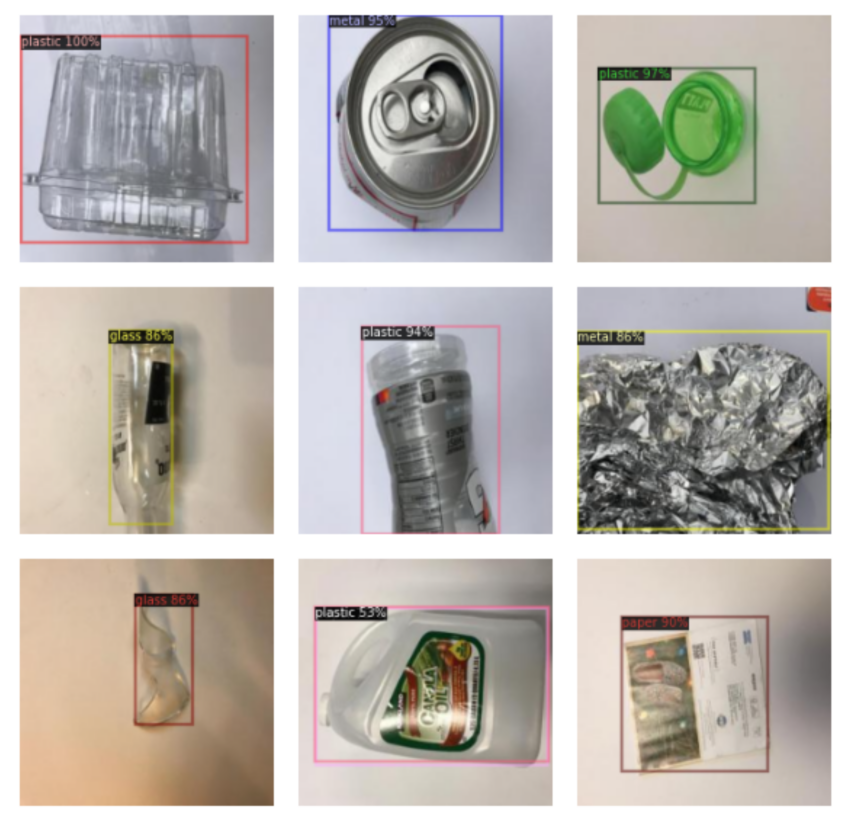

In [5]:
image = cv2.imread("inferences.png")
plt.rcParams['figure.figsize'] = [15, 15]
plt.imshow(image)
plt.axis("off")
plt.show()

### Conclusion

Overall, the object detection we built using transfer learning (R101-FPN) reached an average precision of 89.7% with the IoU-threshold at 0.5 and an average recall of 89.3% with the IoU-threshold between 0.5 and 0.95. In other words, our model could correctly detect and classify 9 out of 10 recycleable materials, and 9 out of 10 predictions our model does would be correct. We find these results satisfying. Using rotations and cropping, we could reach an average precision over 90% but it comes with a reduction in recall to 71.3%. However, that model might be preferable depending on the priorities of the application.

Our findings confirm our hypotheses that transfer learning is a viable method of building a model for a task like object detection of recycleable trash and that inserting perturbations bearing in mind the features of the dataset did help us optimize the model's performance by generating more data to train on and combatting overfitting.

While the results of this study are satisfying for our purposes, there is still room for improvement. There are 16 base models in detectron2's model zoo for object detection, and we only tested the most promising 2 out of that 16. As we discussed above, the better performance on the COCO dataset does not guarantee better performance on our TrashNet, so experimenting with different models from the model zoo could yield even better results. Additionally, most of the images in TrashNet had only one object in them, because it was initially created for image classification models. Therefore, it could be beneficial to expand upon the dataset by taking more pictures with multiple objects in the same picture to increase our model's performance when there are multiple objects in the frame.

We would also like to expand our project into the real world, which could be another avenue for future work and raise awareness for recycling. To do so, we would set up a station in Alvarez College Union with a camera that would feed images to our model and a monitor that would display our model's predictions. This could also help with our data collection if we save the images for further training of our model over time. We could even allow people to give feedback on the accuracy of the predictions and improve the model over time.

Last but not least, it was an enjoyable experience for us to dive deeper into an area of Deep Learning (pun intended) that was not explicitly covered in class, and we were certainly amazed when we first succesfully trained and looked at the inferences of our models on the test dataset. With that said, neither of us are ever going to label images by hand again.

### References

* https://app.roboflow.com/ | We used Roboflow to generate .json files from our images and individual annotations as well as to generate different variations of data augmentation.
* https://curiousily.com/posts/face-detection-on-custom-dataset-with-detectron2-in-python/ | We learnt the specifics of implementing an object detection model using detectron2 API.
* https://www.kaggle.com/dhiiyaur/detectron-2-compare-models-augmentation | This Kaggle notebook introduced us to detectron2 and persuaded us to use it over Tensorflow's object detection API.
* https://towardsdatascience.com/evaluating-performance-of-an-object-detection-model-137a349c517b | We learnt about how to interpret the performance metrics of an object detection model and got our IoU figure from this website.
* https://colab.research.google.com/drive/1-TNOcPm3Jr3fOJG8rnGT9gh60mHUsvaW#scrollTo=WiJ0Ylc_XAUa | We got the code for CocoTrainer from this guide
* https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md | We got our base models from this Zoo and learnt about their AP values on the COCO dataset.
* https://towardsdatascience.com/object-detection-in-6-steps-using-detectron2-705b92575578 | We learnt the format of the .json file required for detectron2 and processed the data following this guide.
* https://github.com/garythung/trashnet | We got our data from here.
* https://arxiv.org/pdf/1611.10012.pdf | The paper by Huang et al. that talks about the correlation between AP50 and AP75.